# Tagging prediction

This note book is to show how an engine can be built to predict the tags of an articles with only the
article text.

Also below questions will be answered at the end of the notebook
1. How well does the model perform
2. How the parameters of the final model is choosed
3. How the model predicts tags from the article text

## High level workflow

**First**, always start with data exploration to get a sense on the distribution of training data. See if any useful features can be engineered for model building and perform data cleaning if necessary.

**Second**, a baseline model will be built to get the idea how well a simple rule-based model can perform.

**At the end**, a machine learning model will be built and fine tuneing.


**Note that Multi-class error rate is used to score the model** 

## 1. Data exploration

In [268]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import re, sys, os, math, jieba
import pandas as pd
import numpy as np
from sklearn import feature_extraction
from sklearn.preprocessing import LabelEncoder  
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb

In [269]:
data_train = pd.read_csv('data/offsite-tagging-training-set.csv', index_col='id')
data_test = pd.read_csv('data/offsite-tagging-test-set.csv', index_col='id')
#print(data_train.isnull().sum())
#print(data_test.isnull().sum())
data_train.dropna(how="all",inplace=True)
data_test.dropna(how="all",inplace=True)
data_train['tags_en'] = data_train.tags
data_train['tags_en'][data_train.tags == '足球'] = 'Football'
data_train['tags_en'][data_train.tags == '梁振英'] = '689'
data_train['tags_en'][data_train.tags == '美國大選'] = 'USA election'
data_train.describe()

,tags,text,tags_en
count,3894,3894,3894
unique,3,3894,3
top,足球,【歐國盃】今日3場焦點：沙加兄弟同場異夢 英俄球迷先惡鬥 今晚3場直播\r\r\nA組｜阿爾...,Football
freq,2123,1,2123


In [270]:
data_test.describe()

,text
count,974
unique,974
top,特朗普的時尚文化意味 領呔、帽子和襟章 美國總統大選舉行在即，今屆選舉兩個候選人很可能是有史...
freq,1


The distribution of tag in the training set is not highly biased.

In [271]:
pd.DataFrame({'cnt':data_train.tags.value_counts(),'%':data_train.tags.value_counts()/data_train.tags.count()})

,cnt,%
足球,2123,0.545198
梁振英,929,0.238572
美國大選,842,0.216230


The article include some html tag as it is in the form of raw HTML text. Although it may contain some information about the tag, analyze the content may makes much more sense. Let's clean all the html tag first.

In [272]:
#clean html tags
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data_train['text_clean'] = data_train['text'].apply(remove_html_tags)
data_test['text_clean'] = data_test['text'].apply(remove_html_tags)
data_train['log_len'] = data_train.text.apply(len).apply(math.log)
data_train['log_len_clean'] = data_train.text_clean.apply(len).apply(math.log)
data_test['log_len'] = data_test.text.apply(len).apply(math.log)
data_test['log_len_clean'] = data_test.text_clean.apply(len).apply(math.log)

The length of articles is distributed similarly for different tags and may not be very helpful in classifing the tag.

<Figure size 28800x9600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

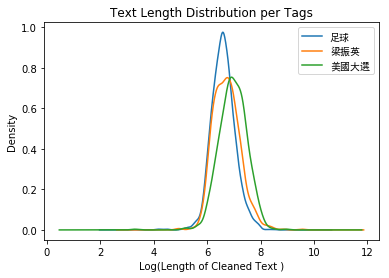

In [273]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55
#prop = matplotlib.font_manager.FontProperties(fname="SimHei.ttf")
#plt.text(0.5, 0.5, s='测试', fontproperties=prop)
#plt.show()
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
data_train.text_clean.apply(len).apply(math.log)[data_train.tags == '足球'].plot(kind='kde')
data_train.text_clean.apply(len).apply(math.log)[data_train.tags == '梁振英'].plot(kind='kde')
data_train.text_clean.apply(len).apply(math.log)[data_train.tags == '美國大選'].plot(kind='kde')
# plots an axis lable
plt.xlabel("Log(Length of Cleaned Text )")
plt.title("Text Length Distribution per Tags")
# sets our legend for our graph.
plt.legend(('足球', '梁振英','美國大選'),loc='best',prop=prop)

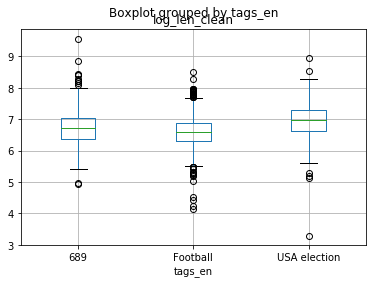

In [274]:
data_train['log_len'] = data_train.text.apply(len).apply(math.log)
data_train['log_len_clean'] = data_train.text_clean.apply(len).apply(math.log)
#data_train.boxplot('log_len',by='tags_en')
data_train.boxplot('log_len_clean',by='tags_en')

Let's look at the content itself as similar articles should use similar wordings/vocabulary.

748 words are extract based on the training corpus (note only those words with document frequecy between 0.05 and 0.7 are extracted)

The words are ordered by inverse document frequency, so the first one appears in fewer document compared to other words

In [275]:
data_train['text_clean'] = data_train['text_clean'].apply(lambda x: " ".join(jieba.cut(x)))
data_test['text_clean'] = data_test['text_clean'].apply(lambda x: " ".join(jieba.cut(x)))
"""
#CountVectorizer
vectorizer_cnt = CountVectorizer(tokenizer=lambda x: x.split(), stop_words='english', min_df=0.05, max_df=0.8)
X = vectorizer_cnt.fit_transform(data_train.text_clean)
vectorizer_cnt.get_feature_names()
"""
#TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(), min_df=0.05, max_df=0.7)
tfidf = vectorizer_tfidf.fit_transform(data_train.text_clean)
indices_tfidf = np.argsort(vectorizer_tfidf.idf_)[::-1]
features_tfidf = vectorizer_tfidf.get_feature_names()
top_features_tfidf = [features_tfidf[i] for i in indices_tfidf]
print('Total {0} features found. (Ordered by idf in descending order)'.format(len(top_features_tfidf)))
print(top_features_tfidf)

Total 748 features found. (Ordered by idf in descending order)
['涉及', '放棄', '通過', '青年', '發揮', '曾經', '壓力', '爭議', '清楚', '逼', '鄭月', '娥', '曾俊華', '二人', '可惜', '國際', '直言', '票', '錢', '資格', '遠', '可見', '超過', '按', '形勢', '北京', '法律', '巴塞', '熱刺', '建功', '拍', '新聞', '擔心', '不可', '傳中', '做法', '身上', '控球', '兩名', '德國', '皮球', '態度', '立場', '早已', '白宮', '實力', '最少', '如今', '開賽', '挑戰', '圍賽', '追', '26', '電視', '司長', '奧', '射手', '鬆', '裏', '突然', '施政', '林', '加入', '能否', '組賽', '上演', '嚴重', '最高', '2008', '這位', '季', '把握', '億', '一位', '意見', '替', '點', '反對', '議員', '可是', '離開', '領隊', '狀態', '透過', '證明', '28', '受傷', '進', '發表', '寫', '制度', '2013', '2016', '議題', '打破', '不滿', '選情', '直播', '周日', '一度', '言論', '擁有', '失去', '全國', '相當', '民調', '意大利', '一般', '解決', '成立', '愈', '真正', '第二', '晉級', '容易', '傳統', '睇', '問到', '進入', '出任', '皆', '買', '利益', '參選人', '值得', '更是', '帶來', '攻擊', '對手', '兩人', '重新', '關', '相反', '當地', '.', '生活', '提到', '員', '擔任', '太', '紐約', '成績', '連續', '唯一', '有意', '全球', 'twitter', '勝出', '笑', '選戰', '梁', '國家隊', '相關', '總統候', '處', '一步', '不要', '道', '昨

**Some cleaning should be done to make sure only meaningful words are used as features later** 
1. remove some common words i.e.雖然, 可能
2. remove single words i.e. 都, 不
3. remove words with only digits or special characters i.e. &, 2008

In [276]:
stop_words = ['nbsp','雖然','可能','可以','不過','不會','沒有']
top_features_tfidf = [x for x in top_features_tfidf if len(x) > 1 and not re.match('^[0-9\.%, ]*$',x) and x not in stop_words]
print('Total {0} features after cleaning. (Ordered by idf in descending order)'.format(len(top_features_tfidf)))
print(top_features_tfidf)

Total 475 features after cleaning. (Ordered by idf in descending order)
['涉及', '放棄', '通過', '青年', '發揮', '曾經', '壓力', '爭議', '清楚', '鄭月', '曾俊華', '二人', '可惜', '國際', '直言', '資格', '可見', '超過', '形勢', '北京', '法律', '巴塞', '熱刺', '建功', '新聞', '擔心', '不可', '傳中', '做法', '身上', '控球', '兩名', '德國', '皮球', '態度', '立場', '早已', '白宮', '實力', '最少', '如今', '開賽', '挑戰', '圍賽', '電視', '司長', '射手', '突然', '施政', '加入', '能否', '組賽', '上演', '嚴重', '最高', '這位', '把握', '一位', '意見', '反對', '議員', '可是', '離開', '領隊', '狀態', '透過', '證明', '受傷', '發表', '制度', '議題', '打破', '不滿', '選情', '直播', '周日', '一度', '言論', '擁有', '失去', '全國', '相當', '民調', '意大利', '一般', '解決', '成立', '真正', '第二', '晉級', '容易', '傳統', '問到', '進入', '出任', '利益', '參選人', '值得', '更是', '帶來', '攻擊', '對手', '兩人', '重新', '相反', '當地', '生活', '提到', '擔任', '紐約', '成績', '連續', '唯一', '有意', '全球', 'twitter', '勝出', '選戰', '國家隊', '相關', '總統候', '一步', '不要', '昨日', '巴西', '方法', '看到', '助攻', '正選', '英格蘭', '媒體', '會議', '連任', '西甲', '無法', '職業', '之前', '完場', '候選人', '會否', '法國', '港元', '關注', '意外', '安排', '球季', '能夠', '延伸', '地方', '不斷', '討論', '拒絕', '生涯

In [277]:
vocab_tfidf = dict(zip(top_features_tfidf,range(len(top_features_tfidf))))

As we can see, some words should be a good features for model building

## 2. Build a Baseline Model

Let's build a baseline model using stop 20 most distinct frequent words of each tag.

As this is probably what an ordinary person would do: use the most frequent distinct words to classify the tag

In [278]:
#CountVectorizer

vectorizer_cnt = {}
cnt = {}
top_features_cnt = {}
top_features_unique_cnt = {}

for i in ['足球', '梁振英','美國大選']:
    vectorizer_cnt[i] = CountVectorizer(tokenizer=lambda x: x.split(), min_df=0.05, max_df=0.9)
    cnt[i] = vectorizer_cnt[i].fit_transform(data_train.text_clean[data_train.tags==i])

    indices_cnt = np.argsort(np.squeeze(np.asarray(cnt[i].sum(axis=0))))[::-1]
    features_cnt = vectorizer_cnt[i].get_feature_names()
    top_features_cnt[i] = [features_cnt[j] for j in indices_cnt]
    top_features_cnt[i] = [x for x in top_features_cnt[i] if len(x) > 1 and not re.match('^[0-9\.%, ]*$',x) and x not in stop_words]
    
top_cnt = 20
top_features_unique_cnt['足球'] = [x for x in top_features_cnt['足球'] if x not in top_features_cnt['梁振英'] and x not in top_features_cnt['美國大選']]
top_features_unique_cnt['梁振英'] = [x for x in top_features_cnt['梁振英'] if x not in top_features_cnt['足球'] and x not in top_features_cnt['美國大選']]
top_features_unique_cnt['美國大選'] = [x for x in top_features_cnt['美國大選'] if x not in top_features_cnt['梁振英'] and x not in top_features_cnt['足球']]

for i in ['足球', '梁振英','美國大選']:
    print('Top {0} most frequent words of {1}'.format(top_cnt,i))
    print()
    print(top_features_unique_cnt[i][0:top_cnt])
    print()

Top 20 most frequent words of 足球

['足球', '球隊', '分鐘', '英超', '球員', '球迷', '入球', '聯賽', '今季', '中場', '阿仙奴', '曼城', '比賽', '利物浦', '曼聯', '作客', '決賽', '球會', '主場', '李斯特']

Top 20 most frequent words of 梁振英

['特首', '行政', '中央', '曾俊華', '施政', '連任', '市民', 'ugl', '鄭月', '司長', '北京', '行李', '會議', '委員會', '房屋', '機場', '基本法', '民主派', '港人', '財政司']

Top 20 most frequent words of 美國大選

['特朗普', '希拉里', '美國', '總統', '共和', '奧巴馬', '桑德斯', '辯論', '選民', '大選', '女性', '移民', '民調', '美國大選', '美元', '紐約', '總統候', '初選', '媒體', '白人']



In [279]:
top_features_unique_cnt['ALL'] = top_features_unique_cnt['足球'][0:top_cnt] + top_features_unique_cnt['梁振英'][0:top_cnt] + top_features_unique_cnt['美國大選'][0:top_cnt]
vocab_cnt = dict(zip(top_features_unique_cnt['ALL'],range(len(top_features_unique_cnt['ALL']))))

vectorizer_cnt['ALL'] = CountVectorizer(tokenizer=lambda x: x.split(), vocabulary=vocab_cnt)
cnt['ALL'] = vectorizer_cnt['ALL'].fit_transform(data_train.text_clean).todense()

total_cnt = {}
total_cnt['足球'] = cnt['ALL'][:,0:top_cnt].sum(axis=1)
total_cnt['梁振英'] = cnt['ALL'][:,top_cnt:2*top_cnt].sum(axis=1)
total_cnt['美國大選'] = cnt['ALL'][:,2*top_cnt:3*top_cnt].sum(axis=1)

preds_baseline = []
error_baseline = []
error = 0
for i in range(len(data_train.index)):
    if total_cnt['足球'][i,0] >= total_cnt['梁振英'][i,0] and total_cnt['足球'][i,0] >= total_cnt['美國大選'][i,0]:
        preds_baseline.append('足球')
    elif total_cnt['梁振英'][i,0] >= total_cnt['足球'][i,0] and total_cnt['梁振英'][i,0] >= total_cnt['美國大選'][i,0]:
        preds_baseline.append('梁振英')
    elif total_cnt['美國大選'][i,0] >= total_cnt['足球'][i,0] and total_cnt['美國大選'][i,0] >= total_cnt['梁振英'][i,0]:
        preds_baseline.append('美國大選')
    if preds_baseline[i] != data_train.tags.values[i]:
        error_baseline.append(int(1))
        error = error + 1
    else:
        error_baseline.append(int(0))
        
#calculate multiplication error of baseline model
print('Multiclass error rate of baseline model on training set = {0}%'.format(round(100*error/len(error_baseline),2)))


Multiclass error rate of baseline model on training set = 1.77%


## 3. Build a ML Model

Let's build a machine learning model using gradient boosting. And the features will be the tfidf of the 475 words identified in data exploration stage.

First, a 10 fold cv will be used to determine to best number of training iteration before training the final model.

Note that the softmax will be the loss function of the model but the printed error is multi-class error rate.


In [280]:
def cust_xgbcv(params, dtrain, num_boost_round, early_stopping_rounds, nfold, verbose_eval, seed, metrics):
    print('Start xgb.cv with max_depth:{0}, num_boost_round:{1}, nfold:{2}'.format(params['max_depth'],num_boost_round,nfold))
    
    model = xgb.cv(params = params, dtrain = d_train, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
               nfold=10, verbose_eval = 20, seed=1234, metrics = 'merror')
    bround = model['test-merror-mean'].idxmin()
    min_cv_loss = model['test-merror-mean'].min()
    print('\nBased on cv result, optimal number of iteration = {0}, cv error = {1}%\n'.format(bround, round(100*min_cv_loss,2)))
    return model, bround

In [281]:
le = LabelEncoder()
train_Y = le.fit_transform(data_train['tags'].values)

#TfidfVectorizer as features
vectorizer_tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(), vocabulary=vocab_tfidf)
train_X = vectorizer_tfidf.fit_transform(data_train.text_clean)
test_X = vectorizer_tfidf.transform(data_test.text_clean)
#features_tfidf = vectorizer_tfidf.get_feature_names()
#unique, counts = np.unique(test_tfidf.getnnz(1), return_counts=True)
#print(dict(zip(unique, counts)))


params = {
        'eta': 0.05,
        'max_depth': 1,
        'objective': 'multi:softmax',
        'eval_metric': 'merror',
        'num_class': 3,
        'silent': 1,
}
num_boost_round = 1000
early_stopping_rounds = 50

d_train = xgb.DMatrix(train_X, train_Y)
d_test = xgb.DMatrix(test_X)
params['max_depth'] = 1
cv_model, num_boost_round = cust_xgbcv(params = params, dtrain = d_train, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
               nfold=10, verbose_eval = 20, seed=1234, metrics = 'merror')
params['max_depth'] = 3
cv_model, num_boost_round = cust_xgbcv(params = params, dtrain = d_train, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
               nfold=10, verbose_eval = 20, seed=1234, metrics = 'merror')
params['max_depth'] = 5
cv_model, num_boost_round = cust_xgbcv(params = params, dtrain = d_train, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
               nfold=10, verbose_eval = 20, seed=1234, metrics = 'merror')
params['max_depth'] = 7
cv_model, num_boost_round = cust_xgbcv(params = params, dtrain = d_train, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
               nfold=10, verbose_eval = 20, seed=1234, metrics = 'merror')


Start xgb.cv with max_depth:1, num_boost_round:1000, nfold:10
[0]	train-merror:0.0472521+0.0010094	test-merror:0.048283+0.00918934
[20]	train-merror:0.0476518+0.00103905	test-merror:0.0477695+0.009002
[40]	train-merror:0.0467385+0.000981271	test-merror:0.0477695+0.00957136
[60]	train-merror:0.0352394+0.000782578	test-merror:0.0364707+0.00947642
[80]	train-merror:0.0307311+0.000777061	test-merror:0.0323623+0.00757219
[100]	train-merror:0.0270502+0.0010761	test-merror:0.0282526+0.00651381
[120]	train-merror:0.0224849+0.000988136	test-merror:0.023371+0.00507266
[140]	train-merror:0.0201736+0.000818374	test-merror:0.0218312+0.00403501
[160]	train-merror:0.0179763+0.000787218	test-merror:0.0197759+0.00502303
[180]	train-merror:0.0157508+0.000785274	test-merror:0.0184913+0.00457344
[200]	train-merror:0.0144098+0.000654569	test-merror:0.0174651+0.00457634
[220]	train-merror:0.013154+0.000413511	test-merror:0.0169516+0.00477408
[240]	train-merror:0.011813+0.000601816	test-merror:0.0156676+0.00

As see, the model perform best when max_depth = 3 and the cv error rate is 1.0% which is better than the baseline model (1.7%)

In [282]:
print('Train final model')
params['max_depth'] = 3
num_boost_round = 240
final_model = xgb.train(params = params, dtrain = d_train, num_boost_round = num_boost_round,
               verbose_eval = 20, evals = [(d_train,'train')])

xgb_pred = list(final_model.predict(d_test))
xgb_pred = [int(x) for x in xgb_pred]
output = pd.DataFrame({'id': data_test.index, 'target': le.inverse_transform(xgb_pred), 'text': data_test.text})
print('Output test result to Q3aFinalAnswer.csv')
output.to_csv("Q3aFinalAnswer.csv".format(K), index=False)


Train final model
[0]	train-merror:0.030046
[20]	train-merror:0.016436
[40]	train-merror:0.014895
[60]	train-merror:0.012327
[80]	train-merror:0.008988
[100]	train-merror:0.006677
[120]	train-merror:0.005136
[140]	train-merror:0.004879
[160]	train-merror:0.004366
[180]	train-merror:0.003852
[200]	train-merror:0.003595
[220]	train-merror:0.002825
[239]	train-merror:0.002311
Output test result to Q3aFinalAnswer.csv


/Users/Shared/anaconda/anaconda3/envs/hk01_offsitetest_py37/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Conclusions

-  A gradient boosting model is trained and from 10 fold cv, the multi-class error rate is 1.0% which is better than the baseline model (1.7%)


-  The final model is trained with max depth of each tree = 3, which is determined by training multiple models with different depths (1/3/5/7). And the number of iteration is 240 which is determined by 10 fold cv result.


-  The model takes the tfidf of some words (which extracted on the data exploration stage) to predict the tag of the article. The idea is that similar articles should have similar wordings inside and so their features vector should be similar.